In [4]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from primeGraph.models import GraphState
from primeGraph.buffer import History
from primeGraph import Graph, START, END
from rich import print as rprint
import time

import logging

logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

class StateForTestWithHistory(GraphState):
    execution_order: History[str]


def test_graph():
    state = StateForTestWithHistory(execution_order=[])
    graph = Graph(state=state)

    @graph.node()
    def task1(state):
        time.sleep(1)
        print("task1")
        return {"execution_order": "task1"}

    @graph.node()
    def task2(state):
        time.sleep(2)
        print("task2")
        return {"execution_order": "task2"}

    @graph.node()
    def task3(state):
        time.sleep(2)
        print("task3")
        return {"execution_order": "task3"}

    @graph.node()
    def task4(state):
        time.sleep(1)
        print("task4")
        return {"execution_order": "task4"}
    
    @graph.node()
    def task5(state):
        time.sleep(1)
        print("task5")
        return {"execution_order": "task5"}
    
    @graph.node()
    def task6(state):
        time.sleep(1)
        print("task6")
        return {"execution_order": "task6"}

    # Create parallel paths
    graph.add_edge(START, "task1")
    graph.add_edge("task1", "task2")
    graph.add_edge("task1", "task3")
    graph.add_edge("task2", "task4")
    graph.add_edge("task3", "task5")
    graph.add_edge("task4", "task6")
    graph.add_edge("task5", "task6")
    graph.add_edge("task6", END)

    graph.compile()

    return graph


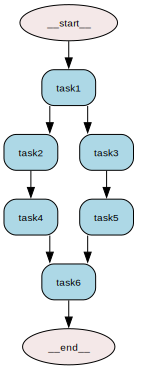

In [5]:
graph = test_graph()
graph.visualize()

In [ ]:
rprint(graph.edges_map)

In [6]:
from primeGraph.graph.engine import GraphExecutor

executor = GraphExecutor(graph)
await executor.execute()


2025-02-04 23:31:03,406 - primeGraph.graph.engine - DEBUG - Executing node '__start__' with state: version='a68afb7bed1b464bc9ee75fa7adf0b26' execution_order=[]
2025-02-04 23:31:03,406 - primeGraph.graph.engine - DEBUG - Executing node 'task1' with state: version='a68afb7bed1b464bc9ee75fa7adf0b26' execution_order=[]
2025-02-04 23:31:04,409 - primeGraph.graph.engine - DEBUG - Node 'task1' launches parallel branches: ['task2', 'task3']
2025-02-04 23:31:04,409 - primeGraph.graph.engine - DEBUG - Executing node 'task2' with state: version='a68afb7bed1b464bc9ee75fa7adf0b26' execution_order=[]
2025-02-04 23:31:04,409 - primeGraph.graph.engine - DEBUG - Executing node 'task3' with state: version='a68afb7bed1b464bc9ee75fa7adf0b26' execution_order=[]


task1


2025-02-04 23:31:06,411 - primeGraph.graph.engine - DEBUG - Executing node 'task5' with state: version='a68afb7bed1b464bc9ee75fa7adf0b26' execution_order=[]
2025-02-04 23:31:06,412 - primeGraph.graph.engine - DEBUG - Executing node 'task4' with state: version='a68afb7bed1b464bc9ee75fa7adf0b26' execution_order=[]


task2task3



2025-02-04 23:31:07,419 - primeGraph.graph.engine - DEBUG - Executing node 'task6' with state: version='a68afb7bed1b464bc9ee75fa7adf0b26' execution_order=[]
2025-02-04 23:31:07,419 - primeGraph.graph.engine - DEBUG - Executing node 'task6' with state: version='a68afb7bed1b464bc9ee75fa7adf0b26' execution_order=[]


task5task4

task6
task6
